#  <font color='#FFE15D'><b>💎 Project 4: Speech Recognition 🔬</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠  **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [2]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.8 MB/s eta 0:00:00


In [3]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00


# 🔴 **Import Libs**

In [1]:
import csv
import os
import glob
from pathlib import Path
from typing import Tuple, Union
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
import torchaudio.functional as AF
from torchaudio._internal import download_url_to_file
from torchaudio.datasets.utils import _extract_tar

from torcheval.metrics import WordErrorRate

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics.aggregation import MeanMetric
from tqdm import tqdm
import string
import random
import math

from IPython.display import Audio
from prettytable import PrettyTable

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, torch, torchaudio, sklearn]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
torch --> 2.1.0+cu121
torchaudio --> 2.1.0+cu121
sklearn --> 1.2.2


# 🔴 **Utils**

In [2]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [4]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [5]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    return nums

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [7]:
def char_to_index():
  char  = "-!',.:;? " + string.ascii_lowercase
  char_dict = {char: idx for idx, char in enumerate(char, 3)}
  char_dict['<OOV>'] = 0
  char_dict['<'] = 1 # SOS
  char_dict['>'] = 2 # EOS
  return char_dict

In [8]:
def index_to_char():
  return {idx: char for char, idx in char_to_index().items()}

In [9]:
def transcript_transform(normalized_transcript):

    text_lengths, text_indices = [], []
    for text in normalized_transcript:
        text = '<' + text + '>'
        text_lengths.append(len(text))
        text_indices.append(torch.LongTensor([char_to_index().get(char.lower(), char_to_index()['<OOV>']) for char in text]))

    return torch.tensor(text_lengths), (text_indices)

transcript_transform(['Speech To Text!', 'Project four: Speech Recognition'])

(tensor([17, 34]),
 [tensor([ 1, 30, 27, 16, 16, 14, 19, 11, 31, 26, 11, 31, 16, 35, 31,  4,  2]),
  tensor([ 1, 27, 29, 26, 21, 16, 14, 31, 11, 17, 26, 32, 29,  8, 11, 30, 27, 16,
          16, 14, 19, 11, 29, 16, 14, 26, 18, 25, 20, 31, 20, 26, 25,  2])])

In [10]:
def greedy_decode(predictions):
    _, max_probs = torch.max(predictions, dim=-1)
    return max_probs

def idx_to_text(indices, idx_to_char):
    # Convert indices to characters using a mapping
    return ''.join([idx_to_char[idx.item()] for idx in indices])

def decode_predictions(predictions, idx_to_char):
    # Apply greedy decoding
    decoded_indices = greedy_decode(predictions)

    # Convert indices to text
    decoded_texts = [idx_to_text(indices, idx_to_char) for indices in decoded_indices]
    return decoded_texts

In [11]:
def filtered_texts(texts):
    return [text.replace('<OOV>', '') for text in texts]

# 🔴 **Arguments**

In [12]:
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_dir = '/content/'
batch_size = 32
num_classes = 38
sample_rate = 22050
new_freq = 16000
n_mels = 80
in_channels = 1
dropout = 0.3
vocab_size = 38
out_channels = [64, 128]
d_model = int(out_channels[-1] * n_mels // 8)
nhead = 4
dim_feedforward = 400
num_encoder_layers = 4
num_decoder_layers = 2

# 🔴 **Dataset**

## 🟠 Load the Dataset

Load the LJ Speech dataset.

Check the structure of the data, such as the waveform samples, corresponding






In [26]:
dataset = datasets.LJSPEECH(root=root_dir,
                            url='https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2',
                            download=True)

100%|██████████| 2.56G/2.56G [02:43<00:00, 16.8MB/s]


In [ ]:
print(f'Number of short audio clips: {len(dataset)}')

Number of short audio clips: 13100


In [ ]:
dataset[1803]

(tensor([[-0.0013, -0.0008, -0.0005,  ..., -0.0007, -0.0009, -0.0010]]),
 22050,
 'As the law stood since the passing of the 9th George IV. c. 40, any two justices might remove a prisoner found to be insane, either on commitment',
 'As the law stood since the passing of the ninth George the fourth c. forty, any two justices might remove a prisoner found to be insane, either on commitment')

### 🟡 **Load Audio** 🎵

In [ ]:
waveform, sample_rate, transcript, normalized_transcript = dataset[15]
print('waveform:\n', waveform)
print('waveform shape:\n', waveform.shape)
print('sample_rate:\n', sample_rate)
print('normalized_transcript:\n', normalized_transcript)

waveform:
 tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])
waveform shape:
 torch.Size([1, 116125])
sample_rate:
 22050
normalized_transcript:
 The Middle Ages brought calligraphy to perfection, and it was natural therefore


In [ ]:
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 22050
Shape: (1, 116125)
Dtype: torch.float32
 - Max:      0.737
 - Min:     -0.607
 - Mean:     0.000
 - Std Dev:  0.100

tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])



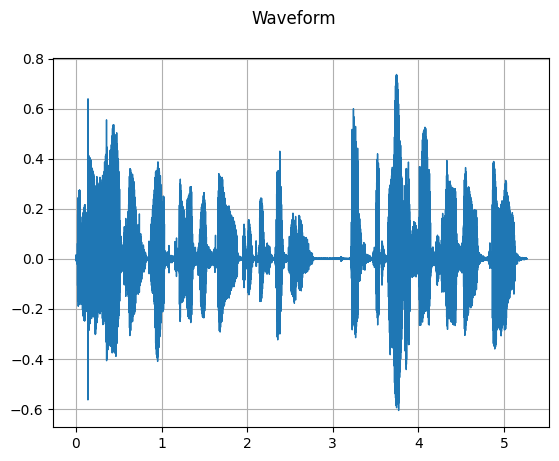

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

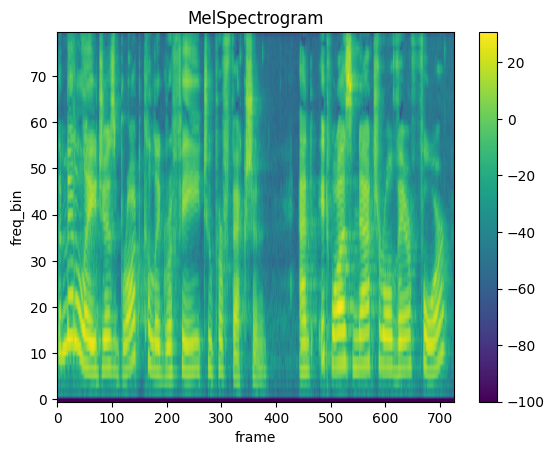

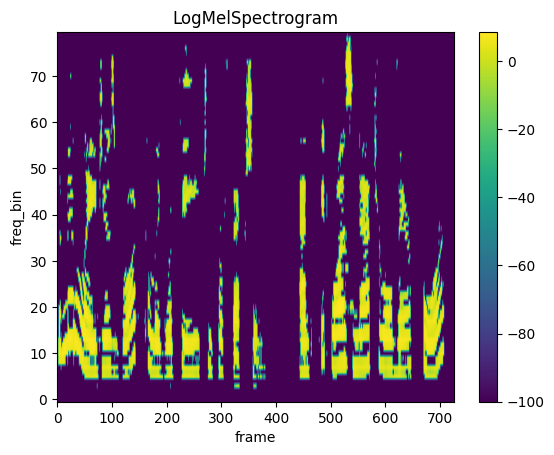

In [ ]:
mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=400,
                                   hop_length=160,
                                   n_mels=n_mels)
melspec = mel_spectrogram(waveform)
log_mel_spec = torch.log(mel_spectrogram(waveform))

plot_spectrogram(melspec[0], title='MelSpectrogram')
plot_spectrogram(log_mel_spec[0], title='LogMelSpectrogram')

## 🟠 Dataset Preparation

Use Source code of [torchaudio.datasets.ljspeech](https://pytorch.org/audio/stable/_modules/torchaudio/datasets/ljspeech.html#LJSPEECH) and Resampled waveforms.

In [13]:
_RELEASE_CONFIGS = {
    "release1": {
        "folder_in_archive": "wavs",
        "url": "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
        "checksum": "be1a30453f28eb8dd26af4101ae40cbf2c50413b1bb21936cbcdc6fae3de8aa5",
    }
}

class LJSPEECH(Dataset):
    """*LJSpeech-1.1* :cite:`ljspeech17` dataset.

    Args:
        root (str or Path): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from.
            (default: ``"https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"wavs"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    def __init__(
        self,
        root: Union[str, Path],
        url: str = _RELEASE_CONFIGS["release1"]["url"],
        folder_in_archive: str = _RELEASE_CONFIGS["release1"]["folder_in_archive"],
        download: bool = False

    ) -> None:

        self._parse_filesystem(root, url, folder_in_archive, download)

    def _parse_filesystem(self, root: str, url: str, folder_in_archive: str, download: bool) -> None:
        root = Path(root)

        basename = os.path.basename(url)
        archive = root / basename

        basename = Path(basename.split(".tar.bz2")[0])
        folder_in_archive = basename / folder_in_archive

        self._path = root / folder_in_archive
        self._metadata_path = root / basename / "metadata.csv"

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    checksum = _RELEASE_CONFIGS["release1"]["checksum"]
                    download_url_to_file(url, archive, hash_prefix=checksum)
                _extract_tar(archive)
        else:
            if not os.path.exists(self._path):
                raise RuntimeError(
                    f"The path {self._path} doesn't exist. "
                    "Please check the ``root`` path or set `download=True` to download it"
                )

        # read {train, valid, test} files
        # with open(split_file) as f:
        #     self.split_samples = f.read().strip().split("\n")

        with open(self._metadata_path, "r", newline="") as metadata:
            flist = csv.reader(metadata, delimiter="|", quoting=csv.QUOTE_NONE)
            self._flist = list(flist)
            #self._flist = [item for sample in self.split_samples for item in self._flist if item[0] == sample]


    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int, str, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            Tuple of the following items;

            Tensor:
                Waveform
            int:
                Sample rate
            str:
                Transcript
            str:
                Normalized Transcript
        """
        line = self._flist[n]
        fileid, transcript, normalized_transcript = line
        fileid_audio = self._path / (fileid + ".wav")

        # load audio
        waveform, sample_rate = torchaudio.load(fileid_audio)

        # resample waveforms
        resampled = T.Resample(sample_rate, new_freq)
        waveform = resampled(waveform)

        return (
            waveform,
            sample_rate,
            transcript,
            normalized_transcript,
        )

    def __len__(self) -> int:
        return len(self._flist)

In [14]:
dataset = LJSPEECH(root=root_dir)

In [15]:
train_set, temp = train_test_split(dataset, test_size=0.3, random_state=42)
test_set, valid_set = train_test_split(temp, test_size=0.5, random_state=42)

len(train_set), len(valid_set), len(test_set)

(9170, 1965, 1965)

## 🟠 EDA

Total Clips	13,100

Total Words	225,715

Total Characters	1,308,678

Total Duration	23:55:17

Mean Clip Duration	6.57 sec

Min Clip Duration	1.11 sec

Max Clip Duration	10.10 sec

Mean Words per Clip	17.23

Distinct Words	13,821

In [ ]:
file_path = os.path.join(root_dir, "LJSpeech-1.1/", "metadata.csv")

df_metadata = pd.read_csv(file_path, sep='|', header=None)
df_metadata.columns = ['waveform_id', 'transcript', 'normalized_transcript']
df_metadata

,waveform_id,transcript,normalized_transcript
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [ ]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   waveform_id            13100 non-null  object
 1   transcript             13100 non-null  object
 2   normalized_transcript  13084 non-null  object
dtypes: object(3)
memory usage: 307.2+ KB


In [ ]:
# basic statistics
num_samples = len(df_metadata)
print(f"Total Clips: {num_samples}")

Total Clips: 13100


In [ ]:
# text analysis
text_lengths = [len(entry) for entry in df_metadata['transcript']]
print(f"Average text length: {sum(text_lengths) / num_samples:.2f}")
print(f"Max text length: {max(text_lengths)}")
print(f"Min text length: {min(text_lengths)}")
print()

total_words = 0
for entry in df_metadata['transcript']:
    words = entry.split()
    total_words += len(words)

print(f"Total words: {total_words}")

Average text length: 98.47
Max text length: 331
Min text length: 5

Total words: 221382


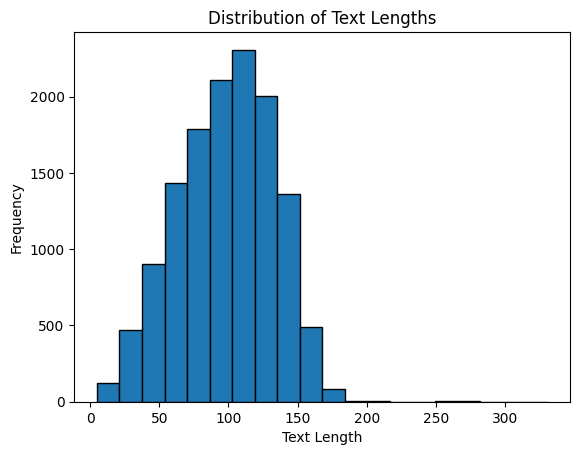

In [ ]:
# text length distribution
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# calculate duration time of 1000 random Clip
wavs_path = os.path.join(root_dir, "LJSpeech-1.1/wavs/*.wav")
paths = glob.glob(wavs_path)
num_random_clip = 1000
random_path = random.sample(paths, num_random_clip)

durations = []
for path in random_path:
    waveform, sampling_rate = torchaudio.load(path)
    duration = waveform.size(1) / sample_rate
    durations.append(duration)

durations_sum = sum(durations)
durations_avg = durations_sum / len(durations)
durations_min = min(durations)
durations_max = max(durations)

print(f"durations_sum: {durations_sum:.2f} sec.")
print(f"durations_avg: {durations_avg:.2f}  sec.")
print(f"durations_min: {durations_min:.2f}  sec.")
print(f"durations_max: {durations_max:.2f}  sec.")

durations_sum: 6470.34 sec.
durations_avg: 6.47  sec.
durations_min: 1.13  sec.
durations_max: 10.10  sec.


## 🟠 Data Processing

## 🟠 Dataloader

In [16]:
def collate_fn(batch):

    waveforms = [metadata[0][0] for metadata in batch]

    # pad waveforms to the length of the longest sequence
    waveforms_padded = pad_sequence(waveforms, batch_first=True)

    # convert text to tensor and get lengths
    normalized_transcript = [metadata[3] for metadata in batch]
    _, text_indices = transcript_transform(normalized_transcript)

    texts_padded = pad_sequence(text_indices, batch_first=True)

    return waveforms_padded, texts_padded

In [17]:
train_loader = DataLoader(train_set, batch_size, num_workers=2, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size, num_workers=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size, num_workers=2, shuffle=False, collate_fn=collate_fn)

In [18]:
waveforms_padded, texts_padded = next(iter(train_loader))
waveforms_padded.shape, texts_padded.shape

(torch.Size([32, 160982]), torch.Size([32, 175]))

# 🔴 **Model**

In [25]:
class MelSpectrogramTransform(nn.Module):
    def __init__(self, n_mels):
        super().__init__()
        self.mel_spec = T.MelSpectrogram(n_mels=n_mels)

    def forward(self, waveform):
        return self.mel_spec(waveform.unsqueeze(1))

In [19]:
class FeatureEmbedding(nn.Module):
    def __init__(self, in_channels=1, out_channels=[64, 128], kernel_size=3, padding=1, stride=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=out_channels[0], kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=stride)

        self.conv2 = nn.Conv2d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=stride)

        self.conv3 = nn.Conv2d(in_channels=out_channels[1], out_channels=out_channels[1], kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(out_channels[1])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=stride)

    def forward(self, x):
        x = self.bn1(self.conv1(x)).relu()
        x = self.pool1(x)
        x = self.bn2(self.conv2(x)).relu()
        x = self.pool2(x)
        x = self.bn3(self.conv3(x)).relu()
        x = self.pool3(x)
        return x

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1, batch_first: bool = False, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.batch_first = batch_first
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        if self.batch_first:
            pos_embedding = pos_embedding.unsqueeze(0)
        else:
            pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        if self.batch_first:
            return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])
        else:
            return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :, :])

In [21]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size, padding_idx: int = 0):
        super(TokenEmbedding, self).__init__()
        self.emb_size = emb_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) # * math.sqrt(self.emb_size)

In [22]:
class SpeechRecognitionModel(nn.Module):
      def __init__(self, n_mels,
                  hidden_dim, num_classes, nhead,
                   num_encoder_layers, num_decoder_layers, dropout=0.3, batch_first=True,
                   activation=nn.Hardtanh()):
          super().__init__()

          # transform waveform to MelSpectrogram
          self.mel_spec = MelSpectrogramTransform(n_mels=n_mels)

          # Convolutional feature extraction
          self.feature_embedding = FeatureEmbedding()

          # Transformer encoder layers
          self.transformer_layer_enc = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                                  nhead=nhead,
                                                                  dropout=dropout,
                                                                  batch_first=batch_first)
          # Transformer encoder
          self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.transformer_layer_enc,
                                                           num_layers=num_encoder_layers)

          # Output embedding
          self.output_embed = TokenEmbedding(num_classes, hidden_dim)

          # Positional encoding for decoder
          self.positional_encoding_decoder = PositionalEncoding(emb_size=hidden_dim,
                                                                dropout=dropout,
                                                                batch_first=batch_first)

          # Transformer decoder layers
          self.transformer_layer_dec = nn.TransformerDecoderLayer(d_model=hidden_dim,
                                                                  nhead=nhead,
                                                                  dropout=dropout,
                                                                  batch_first=batch_first)
          # Transformer decoder
          self.transformer_decoder = nn.TransformerDecoder(decoder_layer=self.transformer_layer_dec,
                                                           num_layers=num_decoder_layers)

          # Fully connected layer for classification
          self.fc = nn.LazyLinear(num_classes)

      def forward(self, waveforms, texts):
          features = self.mel_spec(waveforms)
          features = self.feature_embedding(features) # features dimenstions: batch_size, channels, dimension, seq_lengths
          features = features.permute(0, 3, 2, 1)  # batch_size, seq_lengths, dimension, channels
          features = features.flatten(2) # batch_size, seq_lengths, channels * dimension
          encoder_outputs = self.transformer_encoder(features)
          texts_mask = nn.Transformer.generate_square_subsequent_mask(texts.size(1))
          texts = self.output_embed(texts)
          texts = self.positional_encoding_decoder(texts)
          decoder_outputs = self.transformer_decoder(texts, encoder_outputs, texts_mask)
          outputs = self.fc(decoder_outputs)
          return outputs

In [28]:
model = SpeechRecognitionModel(n_mels, d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers, batch_first=True)

In [27]:
model

SpeechRecognitionModel(
  (mel_spec): MelSpectrogramTransform(
    (mel_spec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (feature_embedding): FeatureEmbedding(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran

In [29]:
model = model.to(device)
outputs_temp = model(waveforms_padded.to(device), texts_padded.to(device))
print('output shape of model: ', outputs_temp.shape)

output shape of model:  torch.Size([32, 175, 38])


In [30]:
print("Number of trainable parameters of model:")
print(f"Total Model: {num_trainable_params(model)}")
print(f"* FeatureEmbedding: {num_trainable_params(model.feature_embedding)}")
print(f"* TransformerLayerEncoder: {num_trainable_params(model.transformer_layer_enc)}")
print(f"* TransformerEncoder: {num_trainable_params(model.transformer_encoder)}")
print(f"* OutputEmbedding: {num_trainable_params(model.output_embed)}")
print(f"* TransformerLayerDecoder: {num_trainable_params(model.transformer_layer_dec)}")
print(f"* TransformerDecoder: {num_trainable_params(model.transformer_decoder)}")
print(f"* FC: {num_trainable_params(model.fc)}")

Number of trainable parameters of model:
Total Model: 114.484262
* FeatureEmbedding: 0.22272
* TransformerLayerEncoder: 11.810048
* TransformerEncoder: 47.240192
* OutputEmbedding: 0.04864
* TransformerLayerDecoder: 18.371328
* TransformerDecoder: 36.742656
* FC: 0.048678


# 🔴 **Config**

In [31]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
metric = WordErrorRate().to(device)

# 🔴 **Train ➰**

🔰 This is the template for train function.



In [32]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = MeanMetric()


  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets[:, :-1])

      loss = loss_fn(outputs.transpose(2, 1), targets[:, 1:])

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight=len(targets))
      tepoch.set_postfix(loss=loss_train.compute().item())

  return model, loss_train.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [33]:
def evaluate(model, test_loader, loss_fn):
  model.eval()
  loss_eval = MeanMetric()

  with torch.inference_mode():
    for inputs, targets in test_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs, targets[:, :-1])

        loss = loss_fn(outputs.transpose(2, 1), targets[:, 1:])

        nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        loss_eval.update(loss.item(), weight=len(targets))

  return loss_eval.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [47]:
model = SpeechRecognitionModel(n_mels,
                               d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers, batch_first=True).to(device)

inputs, texts = next(iter(train_loader))
inputs = inputs.to(device)
texts = texts.to(device)

with torch.no_grad():
    outputs = model(inputs, texts[:, :-1])

    loss = loss_fn(outputs.transpose(2, 1), texts[:, 1:])

print(loss)

tensor(3.7470, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [48]:
mini_train_size = 200
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, batch_size, collate_fn=collate_fn)

In [49]:
model = SpeechRecognitionModel(n_mels,
                               d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers, batch_first=True).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

In [50]:
num_epochs = 10
for epoch in range(num_epochs):
    model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 7/7 [00:05<00:00,  1.28batch/s, loss=2.44]


In [34]:
torch.cuda.empty_cache()

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [52]:
num_epochs = 2

for lr in [0.5, 0.2, 0.1, 0.01]:

  print(f'LR={lr}')
  odel = SpeechRecognitionModel(n_mels, d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers, batch_first=True).to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

  for epoch in range(num_epochs):
    model, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, epoch)
  print()

LR=0.5


Epoch 1: 100%|██████████| 62/62 [00:51<00:00,  1.21batch/s, loss=2.56]



LR=0.2


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.19batch/s, loss=2.29]



LR=0.1


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.18batch/s, loss=2.19]



LR=0.01


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.18batch/s, loss=2.13]

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [36]:
num_epochs = 2
hyper_parameters_table = PrettyTable([ "Learning Rate", "Weight decay", "loss"])

for lr in [0.15, 0.1, 0.05]:
    for wd in [1e-6, 1e-5, 1e-4]:
        model = SpeechRecognitionModel(n_mels, d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers, batch_first=True).to(device)

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

        print(f'LR={lr}, WD={wd}')
        for epoch in range(num_epochs):
            model, loss = train_one_epoch(model, valid_loader, loss_fn, optimizer, epoch)

            if epoch == num_epochs - 1:
                hyper_parameters_table.add_row([lr, wd, f'{loss:.4f}'])

        print()
    hyper_parameters_table.add_row([20*'-', 20*'-', 20*'-'])

print(hyper_parameters_table)

LR=0.15, WD=1e-06


Epoch 1: 100%|██████████| 62/62 [00:53<00:00,  1.17batch/s, loss=2.44]



LR=0.15, WD=1e-05


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.18batch/s, loss=2.44]



LR=0.15, WD=0.0001


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.19batch/s, loss=2.44]



LR=0.1, WD=1e-06


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.19batch/s, loss=2.44]



LR=0.1, WD=1e-05


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.19batch/s, loss=2.43]



LR=0.1, WD=0.0001


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.19batch/s, loss=2.44]



LR=0.05, WD=1e-06


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.18batch/s, loss=2.43]



LR=0.05, WD=1e-05


Epoch 1: 100%|██████████| 62/62 [00:53<00:00,  1.17batch/s, loss=2.43]



LR=0.05, WD=0.0001


Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.18batch/s, loss=2.43]


+----------------------+----------------------+----------------------+
|    Learning Rate     |     Weight decay     |         loss         |
+----------------------+----------------------+----------------------+
|         0.15         |        1e-06         |        2.4429        |
|         0.15         |        1e-05         |        2.4435        |
|         0.15         |        0.0001        |        2.4435        |
| -------------------- | -------------------- | -------------------- |
|         0.1          |        1e-06         |        2.4352        |
|         0.1          |        1e-05         |        2.4350        |
|         0.1          |        0.0001        |        2.4356        |
| -------------------- | -------------------- | -------------------- |
|         0.05         |        1e-06         |        2.4280        |
|         0.05         |        1e-05         |        2.4272        |
|         0.05         |        0.0001        |        2.4305        |
| ---

## 🟠 Main Loop

In [56]:
model = SpeechRecognitionModel(n_mels, d_model, num_classes, nhead,
                               num_encoder_layers, num_decoder_layers,
                               batch_first=True).to(device)

In [57]:
lr = 0.1
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [58]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [59]:
num_epochs = 20

for epoch in range(epoch_counter + 1, num_epochs):

    # Train
    model, loss_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    # Validation
    loss_valid = evaluate(model, valid_loader, loss_fn)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    if loss_valid < best_loss_valid:
        torch.save(model, f'/content/drive/MyDrive/project-4-speech-recognition/model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Valid: Loss = {loss_valid:.4}')
    print()

    epoch_counter += 1

Epoch 1: 100%|██████████| 287/287 [04:02<00:00,  1.18batch/s, loss=2.46]


Model Saved!
Valid: Loss = 2.345



Epoch 2: 100%|██████████| 287/287 [04:02<00:00,  1.18batch/s, loss=2.29]


Model Saved!
Valid: Loss = 2.169



Epoch 3: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=2.18]


Model Saved!
Valid: Loss = 2.034



Epoch 4: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=2.08]


Model Saved!
Valid: Loss = 1.949



Epoch 5: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=2.01]


Model Saved!
Valid: Loss = 1.869



Epoch 6: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.95]


Model Saved!
Valid: Loss = 1.808



Epoch 7: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.89]


Model Saved!
Valid: Loss = 1.747



Epoch 8: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.85]


Model Saved!
Valid: Loss = 1.687



Epoch 9: 100%|██████████| 287/287 [04:00<00:00,  1.19batch/s, loss=1.8]


Model Saved!
Valid: Loss = 1.639



Epoch 10: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.76]


Model Saved!
Valid: Loss = 1.598



Epoch 11: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.72]


Model Saved!
Valid: Loss = 1.54



Epoch 12: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.67]


Model Saved!
Valid: Loss = 1.511



Epoch 13: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.63]


Model Saved!
Valid: Loss = 1.444



Epoch 14: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.58]


Model Saved!
Valid: Loss = 1.392



Epoch 15: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.54]


Model Saved!
Valid: Loss = 1.338



Epoch 16: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.49]


Model Saved!
Valid: Loss = 1.302



Epoch 17: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.43]


Model Saved!
Valid: Loss = 1.225



Epoch 18: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.38]


Model Saved!
Valid: Loss = 1.181



Epoch 19: 100%|██████████| 287/287 [04:02<00:00,  1.18batch/s, loss=1.33]


Model Saved!
Valid: Loss = 1.119



Train model more epochs.

In [60]:
num_epochs = 10

for epoch in range(epoch_counter + 1, epoch_counter + num_epochs):

    # Train
    model, loss_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    # Validation
    loss_valid = evaluate(model, valid_loader, loss_fn)


    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)


    if loss_valid < best_loss_valid:
        torch.save(model, f'/content/drive/MyDrive/project-4-speech-recognition/best-model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Valid: Loss = {loss_valid:.4}')
    print()

    epoch_counter += 1

Epoch 20: 100%|██████████| 287/287 [04:02<00:00,  1.18batch/s, loss=1.28]


Model Saved!
Valid: Loss = 1.062



Epoch 21: 100%|██████████| 287/287 [04:02<00:00,  1.18batch/s, loss=1.23]


Model Saved!
Valid: Loss = 1.002



Epoch 22: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.18]


Valid: Loss = 1.065



Epoch 23: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.14]


Model Saved!
Valid: Loss = 0.9165



Epoch 24: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=1.09]


Valid: Loss = 1.093



Epoch 25: 100%|██████████| 287/287 [04:00<00:00,  1.19batch/s, loss=1.05]


Model Saved!
Valid: Loss = 0.8849



Epoch 26: 100%|██████████| 287/287 [04:00<00:00,  1.19batch/s, loss=1.01]


Model Saved!
Valid: Loss = 0.8724



Epoch 27: 100%|██████████| 287/287 [04:01<00:00,  1.19batch/s, loss=0.972]


Valid: Loss = 1.154



Epoch 28: 100%|██████████| 287/287 [04:00<00:00,  1.19batch/s, loss=0.935]


Valid: Loss = 1.175



## 🟠 Plot

🔰 Plot learning curves

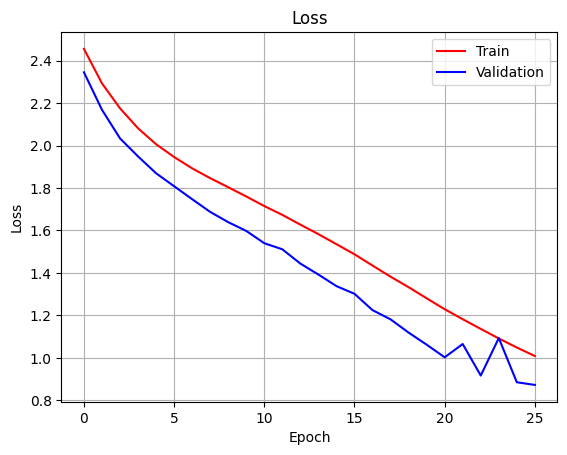

In [71]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True, linestyle = '-')
plt.legend();

# 🔴 **Test**

🔰 Test your model using data from the test set

In [72]:
best_model = torch.load(f'/content/drive/MyDrive/project-4-speech-recognition/best-model.pt')
best_model.eval()

SpeechRecognitionModel(
  (mel_spec): MelSpectrogramTransform(
    (mel_spec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (feature_embedding): FeatureEmbedding(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran

In [73]:
loss_test = evaluate(best_model, test_loader, loss_fn)
loss_test

0.8726366758346558

# 🔴 **Decode Text**

In [83]:
def decode_text(model, wave_input, texts):
    with torch.no_grad():
        preds = best_model(wave_input.to(device), texts.to(device)[:, :-1])

        decoded_preds = decode_predictions(preds, index_to_char())

        decoded_preds = [str(pred) for pred in decoded_preds]
        target_texts_string = [''.join([index_to_char()[idx.item()] for idx in target]) for target in texts]
    return decoded_preds, target_texts_string

In [90]:
bs = 5
mini_test_loader = DataLoader(mini_train_dataset, batch_size=bs, collate_fn=collate_fn, shuffle=True)
wave_input, texts = next(iter(mini_test_loader))

In [87]:
pred_text, target_texts = decode_text(best_model, wave_input, texts)
pred_texts = [text.replace('>', '') for text in pred_text]

for i in range(bs):
   print(f'Target: {filtered_texts(target_texts)[i]}')
   print(f'Prediction: {pred_texts[i]}')
   print()

Target: <asking his brother why he supported the american government and what ideals he put forward, oswald wrote, quote,>
Prediction: askeng his brother wai hi supperted tha anerican hovernment,ond woit h  als he crr ior ard  qnwald waoted auote,  

Target: <and recovery is speeding up to a point where the dangers of nineteen twenty-nine are again becoming possible,>
Prediction: and recovere is tueaaing tp to arpointeihere the danger  sf nineteen thenty-nine orr igain tecammng trisible.

Target: <mr. cope, the governor of newgate, having been communicated with, proceeded to winchester, where he at once identified williams.>
Prediction: mrs sare  the savernor hf newgate  teveng teen cammunicated tith  tropeddid th whthh ster  there se wrtwnce anentificd titliams.

Target: <then the gills gradually dry up, as the lungs develop, and they now breathe wholly by lungs, but still retain the tail.>
Prediction: than the givls wrenual y toi op  as the longs tobenon  and they now briadieraaolee 